In [2]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.waveform import taper_timeseries
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import gen_wf, get_h, overlap_cplx_wfs, match_wfs, shifted_f, shifted_e, chirp2total, trim_wf, ceiltwo, taper_wf, gen_teob_wf, gen_psd, chirp_degeneracy_line

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
def match_hn(wf_h, wf_t, f_low, psd, dominant_mode=0, return_index=False):
    """
    Calculates match between fiducial waveform harmonics and trial waveform harmonics.  It uses the time shift 
    from the leading harmonic (assumed to be the first one) to determine the appropriate time shift for the other 
    harmonics. This ensures the 'match' is calculated for h1 and h2,...,hn at the same time.

    Parameters:
        wf_h: dictionary of fiducial h1,...,hn waveforms.
        wf_t: dictionary of trial waveforms (assumed to have same keys)
        f_low: Starting frequency of waveforms.
        return_index: Whether to return index shift of h1 match.
        
    Returns:
        Dictionary Complex matches of trial waveform components to fiducial waveform components.
    """
    # Perform match dominant mode

    wf_t[dominant_mode].resize(len(wf_h[dominant_mode]))

    m0_amp, m0_index, m0_phase = match(wf_t[dominant_mode].real(), wf_h[dominant_mode].real(), psd=psd, 
                                       low_frequency_cutoff=f_low+3, subsample_interpolation=True, return_phase=True)
    
    matches = {}
    for k in wf_h.keys():
        h = wf_t[k].real()
        h.resize(len(wf_h[k]))
        matches[k] = abs(overlap_cplx(wf_h[k].real(), h.cyclic_time_shift(m0_index * wf_h[dominant_mode].delta_t), psd=psd, low_frequency_cutoff=f_low+3))
    
    return matches

# Comparing waveform components

In [3]:
f_low = 10
e0 = 0.2
mc0 = 24
q = 2
sample_rate = 4096
freq_type = 'orbitaveraged'

In [4]:
hs = {}
s = {}

In [5]:
hh, hs[0], hs[1], hs[-1], hs[2], s[0], s[1], s[2], s[3] = get_h([1,1,1,1], f_low, e0, 
                                                               chirp2total(mc0, q), q, 
                                                               GS_normalisation=False, 
                                                               comp_normalisation=False,
                                                               sample_rate = sample_rate, approximant='TEOBResumS')

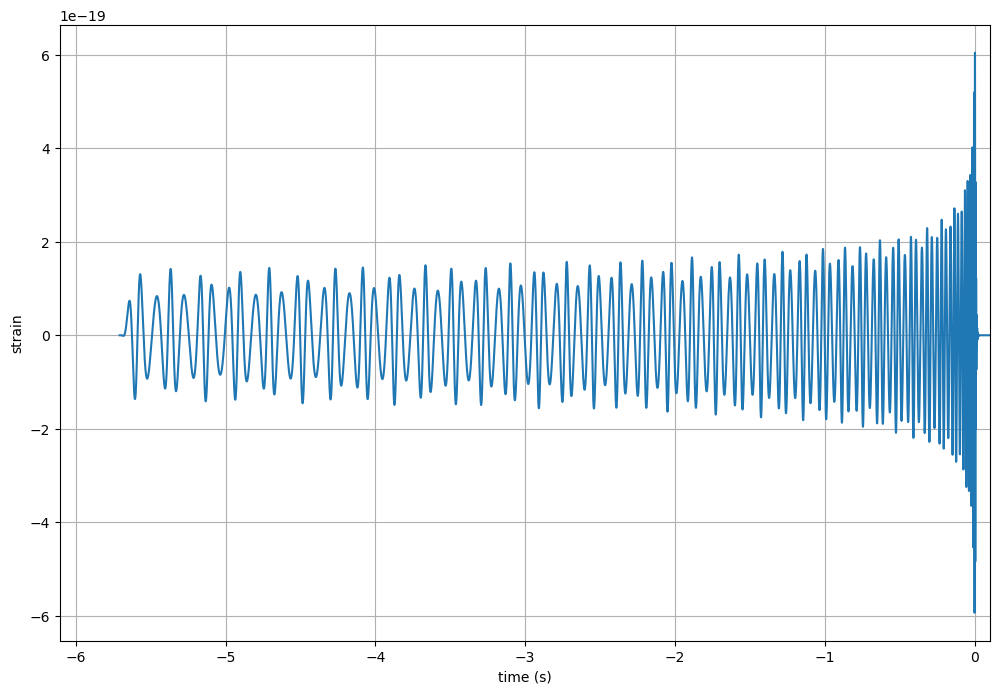

In [6]:
plt.figure(figsize=(12,8))
plt.plot(hh.sample_times, hh.real() )
plt.xlim(plt.xlim()[0], 0.1)
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.grid()

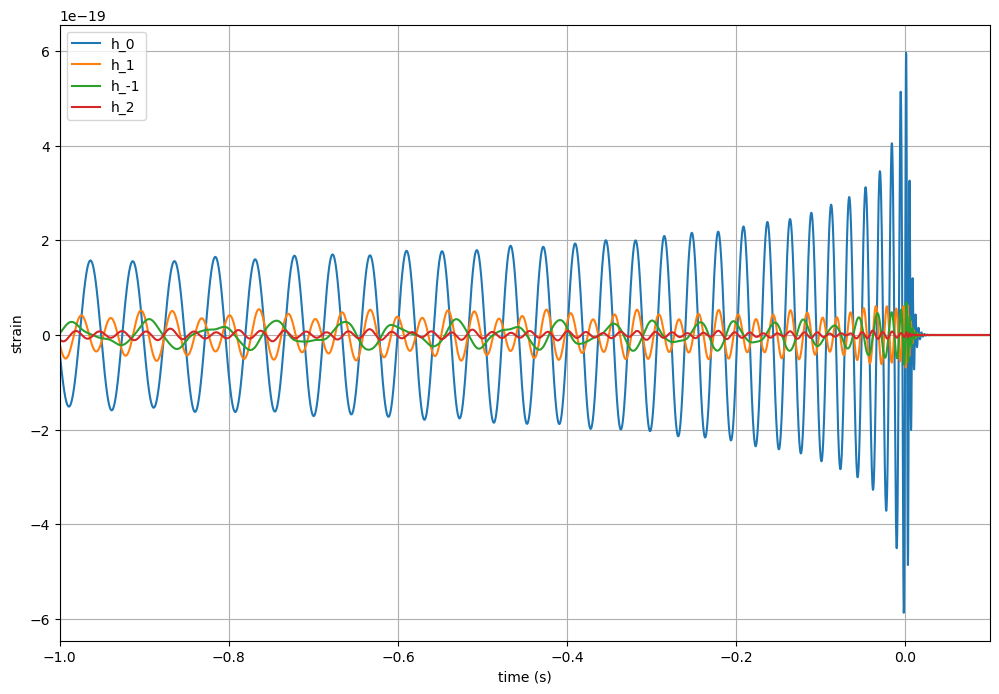

In [7]:
plt.figure(figsize=(12,8))
for k, h in hs.items():
    plt.plot(h.sample_times, h.real(), label='h_%d' %k)
plt.legend()
# plt.xlim(plt.xlim()[0], 0.1)
plt.xlim(-1, 0.1)
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.grid()

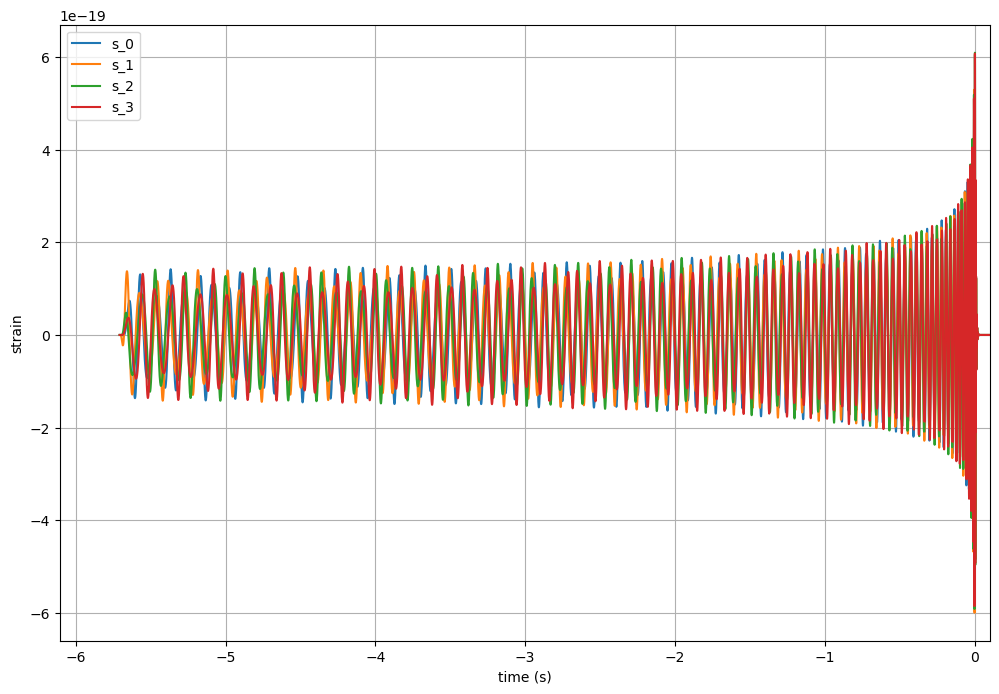

In [8]:
plt.figure(figsize=(12,8))
for k, h in s.items():
    plt.plot(h.sample_times, h.real(), label='s_%d' %k)
plt.legend()
plt.xlim(plt.xlim()[0], 0.1)
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.grid()

In [9]:
psd = gen_psd(hh.real(), 10)

In [10]:
kk = hs.keys()

for k in kk:
    for l in kk:
        if l>=k:
            over = abs(overlap_cplx(hs[k].real(), hs[l].real(), psd=psd, 
                                    low_frequency_cutoff=10+3))
            print("overlap between %d and %d: %.2f" % (k, l, over))

overlap between 0 and 0: 1.00
overlap between 0 and 1: 0.12
overlap between 0 and 2: 0.05
overlap between 1 and 1: 1.00
overlap between 1 and 2: 0.10
overlap between -1 and 0: 0.26
overlap between -1 and 1: 0.17
overlap between -1 and -1: 1.00
overlap between -1 and 2: 0.08
overlap between 2 and 2: 1.00


## Harmonic overlap across parameter space

In [11]:
npts = 17
mchirps, esqs = np.mgrid[22.5:24.5:npts*1j, 0:0.16:npts*1j]
matches = {}
aligned_matches = {}
for k in kk:
    matches[k] = np.zeros_like(mchirps)
    aligned_matches[k] = np.zeros_like(mchirps)

In [ ]:
ht = {}

for (i, mc) in np.ndenumerate(mchirps):
    e2 = esqs[i]
    _, ht[0], ht[1], ht[-1], ht[2], _, _, _, _ = get_h([1,1,1,1], f_low, np.sqrt(e2), 
                                                      chirp2total(mc, q), q, 
                                                      GS_normalisation=False, 
                                                      comp_normalisation=False,
                                                      sample_rate = sample_rate, 
                                                      approximant='TEOBResumS')

    am = match_hn(hs, ht, f_low, psd, dominant_mode=0, return_index=False)

    for k in kk:
        ht[k].resize(len(hs[k]))
        matches[k][i] = match(ht[k].real(), hs[k].real(), psd=psd, low_frequency_cutoff=10+3,
                              subsample_interpolation=True)[0]
        aligned_matches[k][i] = am[k]
         
        

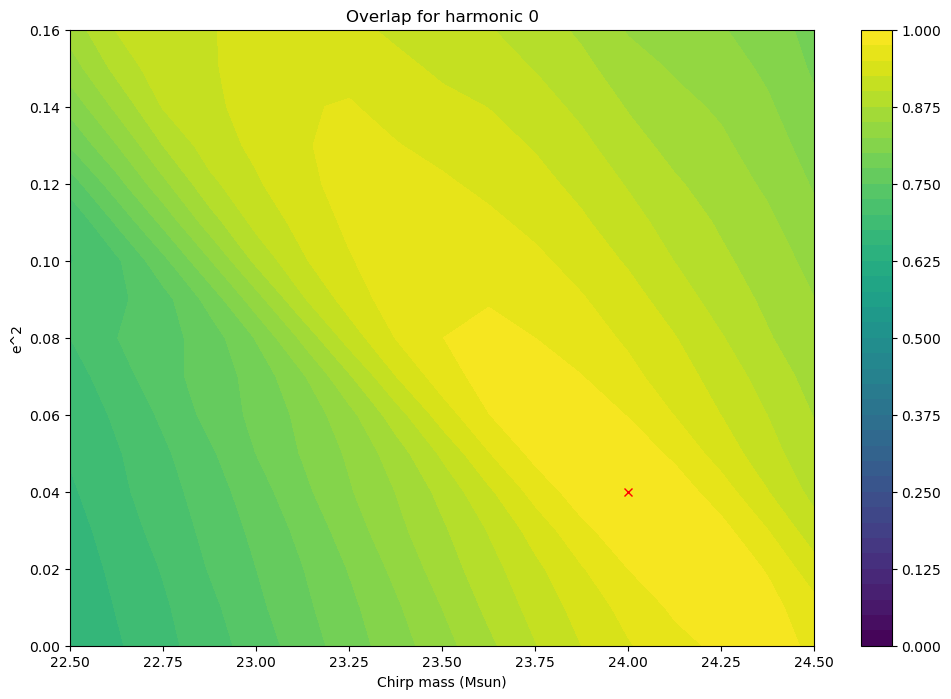

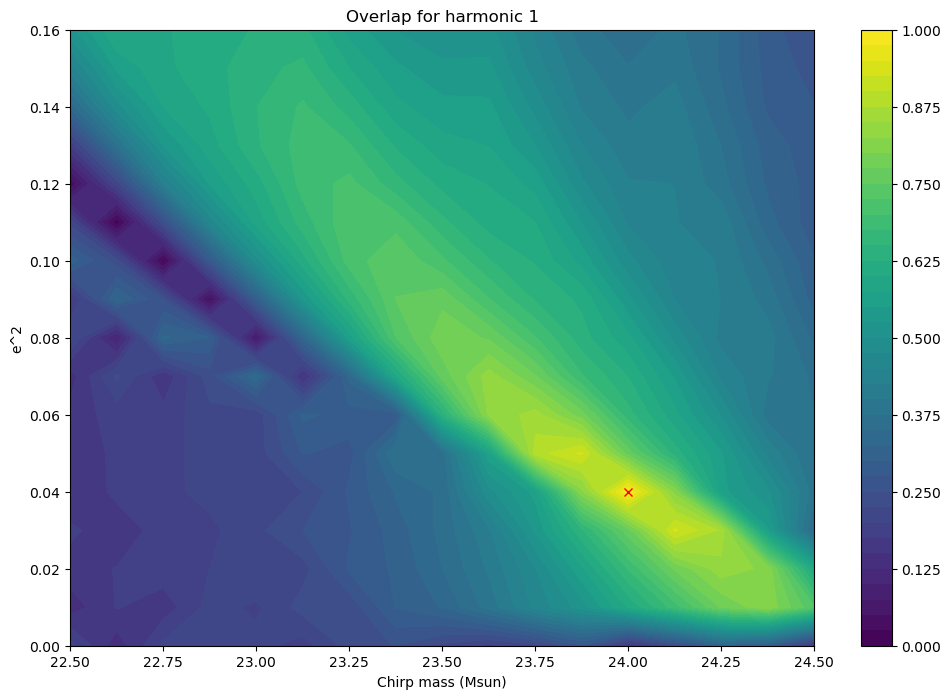

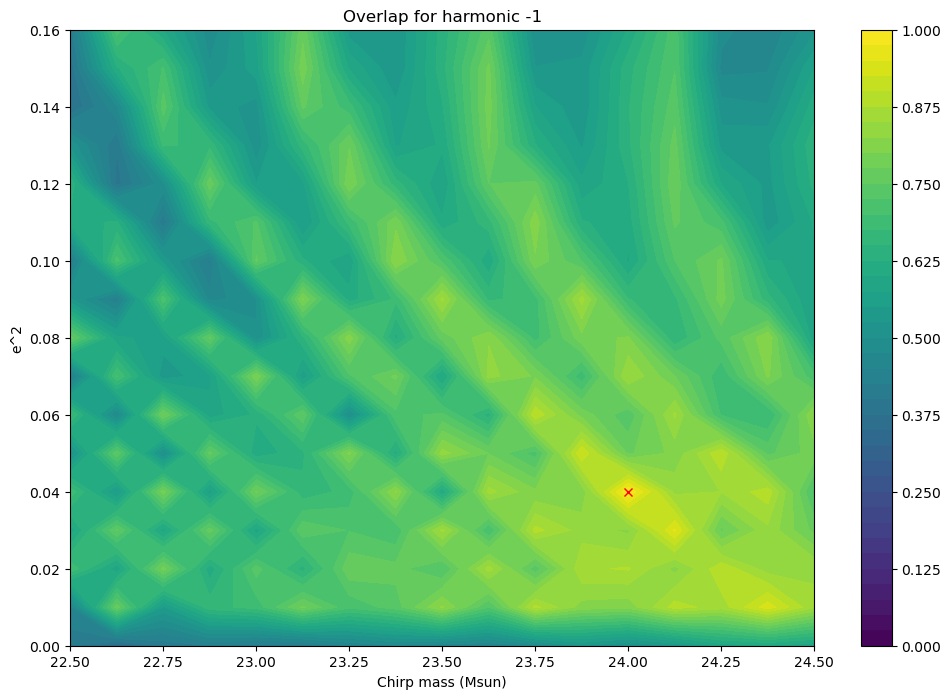

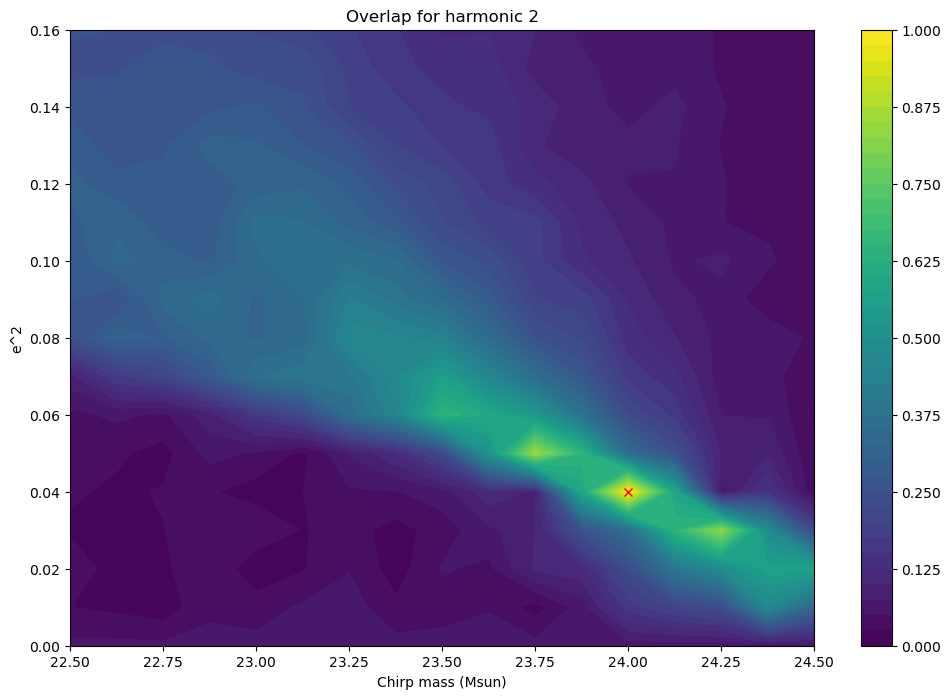

In [18]:
for k in kk:
    plt.figure(figsize=(12, 8))
    plt.contourf(mchirps, esqs, aligned_matches[k], levels=np.linspace(0,1,41))
    plt.colorbar()
    plt.xlabel('Chirp mass (Msun)')
    plt.ylabel('e^2')
    plt.title('Overlap for harmonic %d' % k)
    plt.plot(mc0, e0**2, 'rx')
    plt.savefig('overlap_mc_%d_e_%s_harmonic_%d.png' % (mc0, str(e0).replace('.','_'), k) )

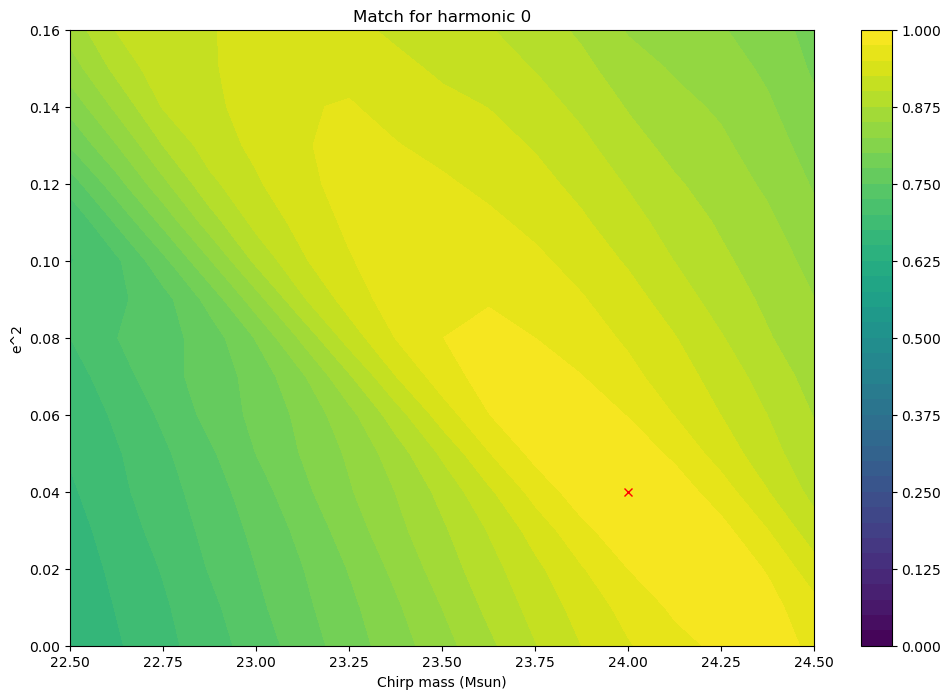

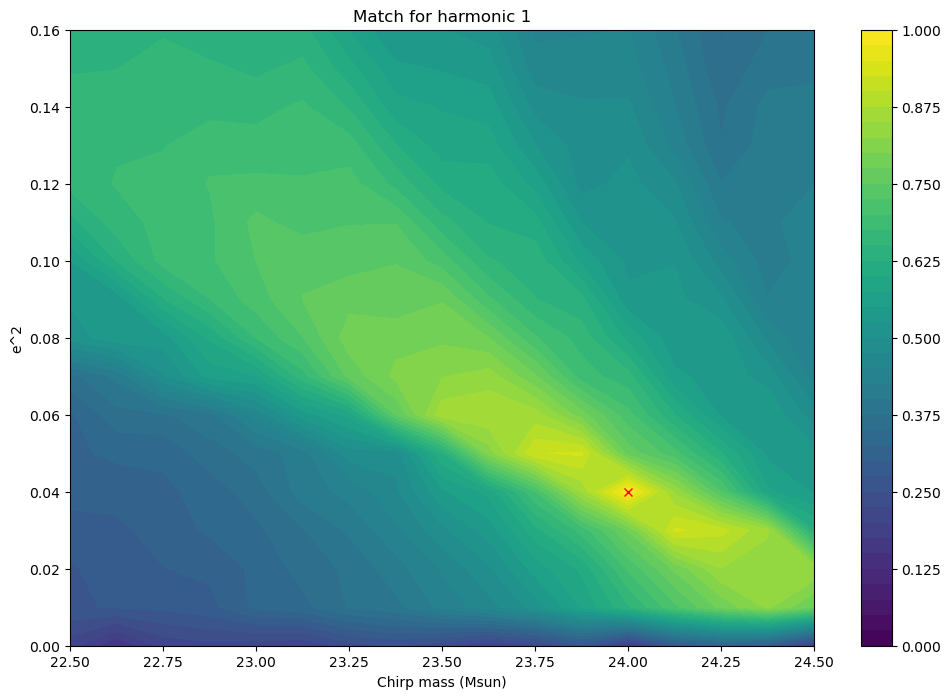

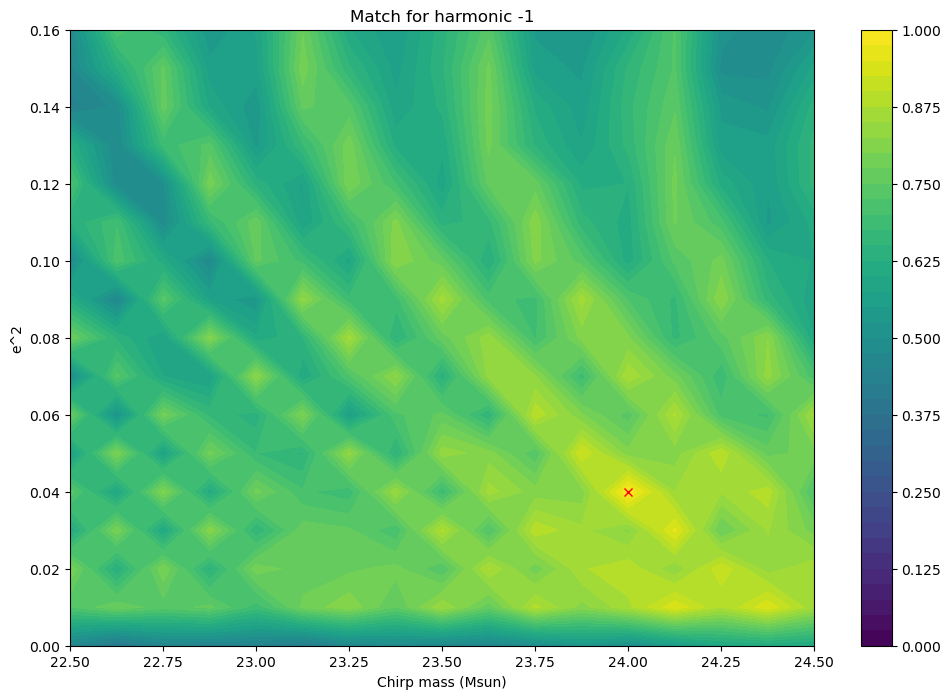

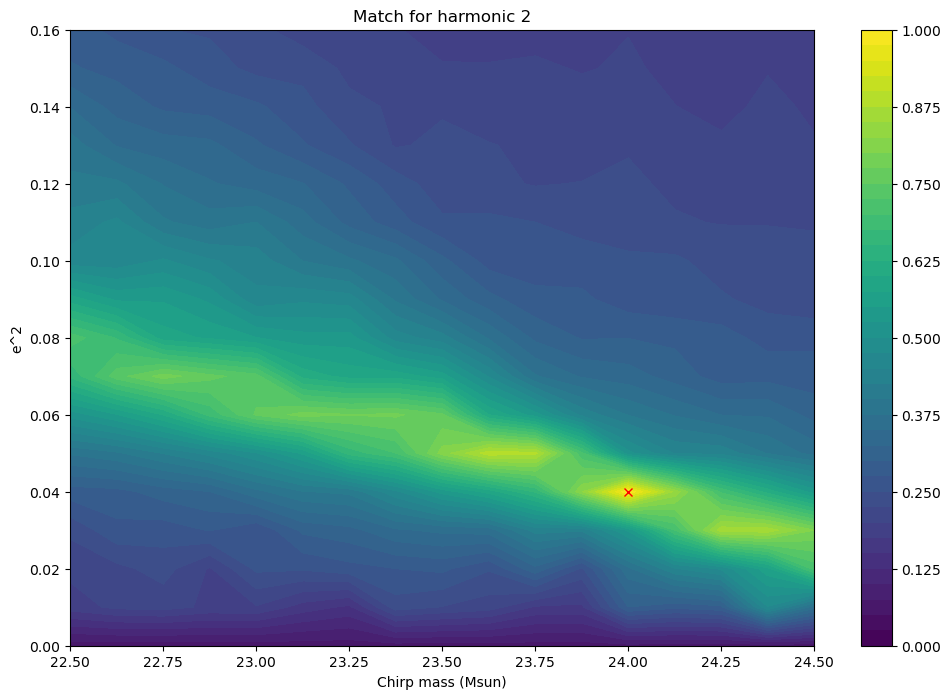

In [19]:
for k in kk:
    plt.figure(figsize=(12, 8))
    plt.contourf(mchirps, esqs, matches[k], levels=np.linspace(0,1,41))
    plt.colorbar()
    plt.xlabel('Chirp mass (Msun)')
    plt.ylabel('e^2')
    plt.title('Match for harmonic %d' % k)
    plt.plot(mc0, e0**2, 'rx')
    plt.savefig('match_mc_%d_e_%s_harmonic_%d.png' % (mc0, str(e0).replace('.','_'), k) )


# Higher resolution

Using CIT we can look at these grids at higher resolutions (especially useful for h_-1 above) and at a range of different fiducial parameters.

In [4]:
def linear_degeneracy_line(zero_ecc_chirp, eccs, sample_rate=4096, f_low=10, q=2, f_match=20, return_delta_m=False):

    # Zero ecc waveform
    h = gen_wf(f_low, 0, chirp2total(zero_ecc_chirp, q), q, sample_rate, 'TEOBResumS')
    psd = gen_psd(h, f_low)
    h = h.real().to_frequencyseries()
    
    # Compute integrals
    int_49_9 = sigmasq(h*h.sample_frequencies**(-49/18), psd=psd, low_frequency_cutoff=f_match)
    int_5_3 = sigmasq(h*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_match)
    int_34_9 = sigmasq(h*h.sample_frequencies**(-34/18), psd=psd, low_frequency_cutoff=f_match)
    int_10_3 = sigmasq(h*h.sample_frequencies**(-10/6), psd=psd, low_frequency_cutoff=f_match)
    int_norm = sigmasq(h, psd=psd, low_frequency_cutoff=f_match)
    
    # Compute constant
    int_constant = (int_49_9 - int_5_3*int_34_9/int_norm)/(int_10_3 - int_5_3**2/int_norm)
    alpha = (1413/1462)*f_low**(19/9)*int_constant

    # Compute line
    approx_chirps = zero_ecc_chirp*(1-alpha*eccs**2)

    # Return delta m if requested
    if return_delta_m:
        approx_delta_ms = 5*alpha*eccs**2/3
        return approx_chirps, approx_delta_m
    else:
        return approx_chirps

In [3]:
fid_e = 0.1
fid_chirp = 24

# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_1', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess)['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)
approx_chirp_vals = linear_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/t

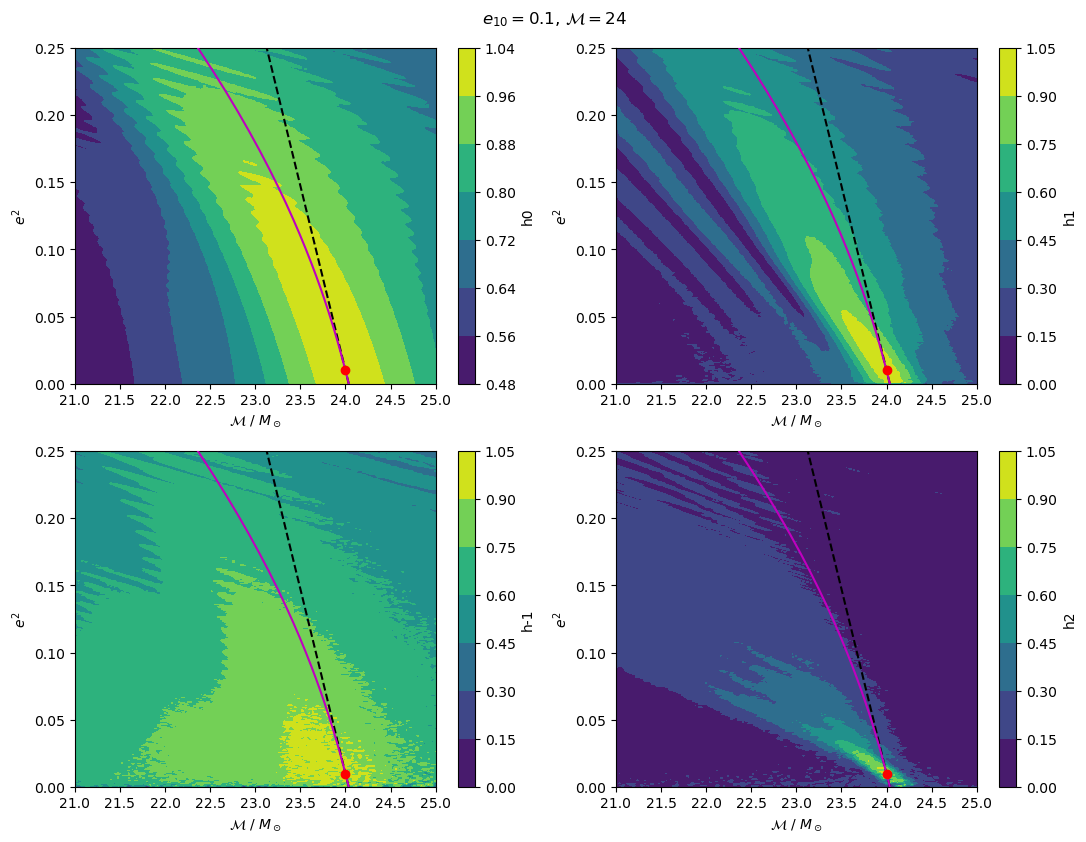

In [4]:
# Plot each grid
keys = ['h0', 'h1', 'h-1', 'h2']
plt.figure(figsize=(6.4*2,4.8*2))
for i in range(4):
    key = keys[i]

    # Plot grid
    plt.subplot(2, 2, i+1)
    plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals']**2, data[fid_chirp][fid_e][key])
    plt.colorbar(label=key)
    plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()

    # Plot degeneracy lines
    plt.plot(sparse_chirp_vals, sparse_e_vals**2, c='m', label='full', zorder=3)
    plt.plot(approx_chirp_vals, sparse_e_vals**2, c='k', ls='dashed', label='linear')

    # Plot formatting
    plt.ylim(ylims)
    plt.xlim(xlims)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
plt.suptitle('$e_{10}=$'+str(fid_e)+', $\mathcal{M}=$'+str(fid_chirp), x=0.5, y=0.92)
plt.show()

## All fiducial params

In [5]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_1', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

# Calculate degeneracy lines
sparse_chirp_vals = {}
approx_chirp_vals = {}
for i, fid_chirp in enumerate(data.keys()):
    sparse_chirp_vals[fid_chirp] = {}
    approx_chirp_vals[fid_chirp] = {}
    for j, fid_e in enumerate(data[fid_chirp].keys()):
        sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
        init_guess = fid_chirp
        sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
        f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
        q = data[fid_chirp][fid_e]['fid_params']['q']
        min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
        zero_ecc_chirp_mass = minimize(min_func, init_guess, bounds=[(0.75*init_guess, 1.25*init_guess)], method='Nelder-Mead')['x']
        sparse_chirp_vals[fid_chirp][fid_e] = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)
        approx_chirp_vals[fid_chirp][fid_e] = linear_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

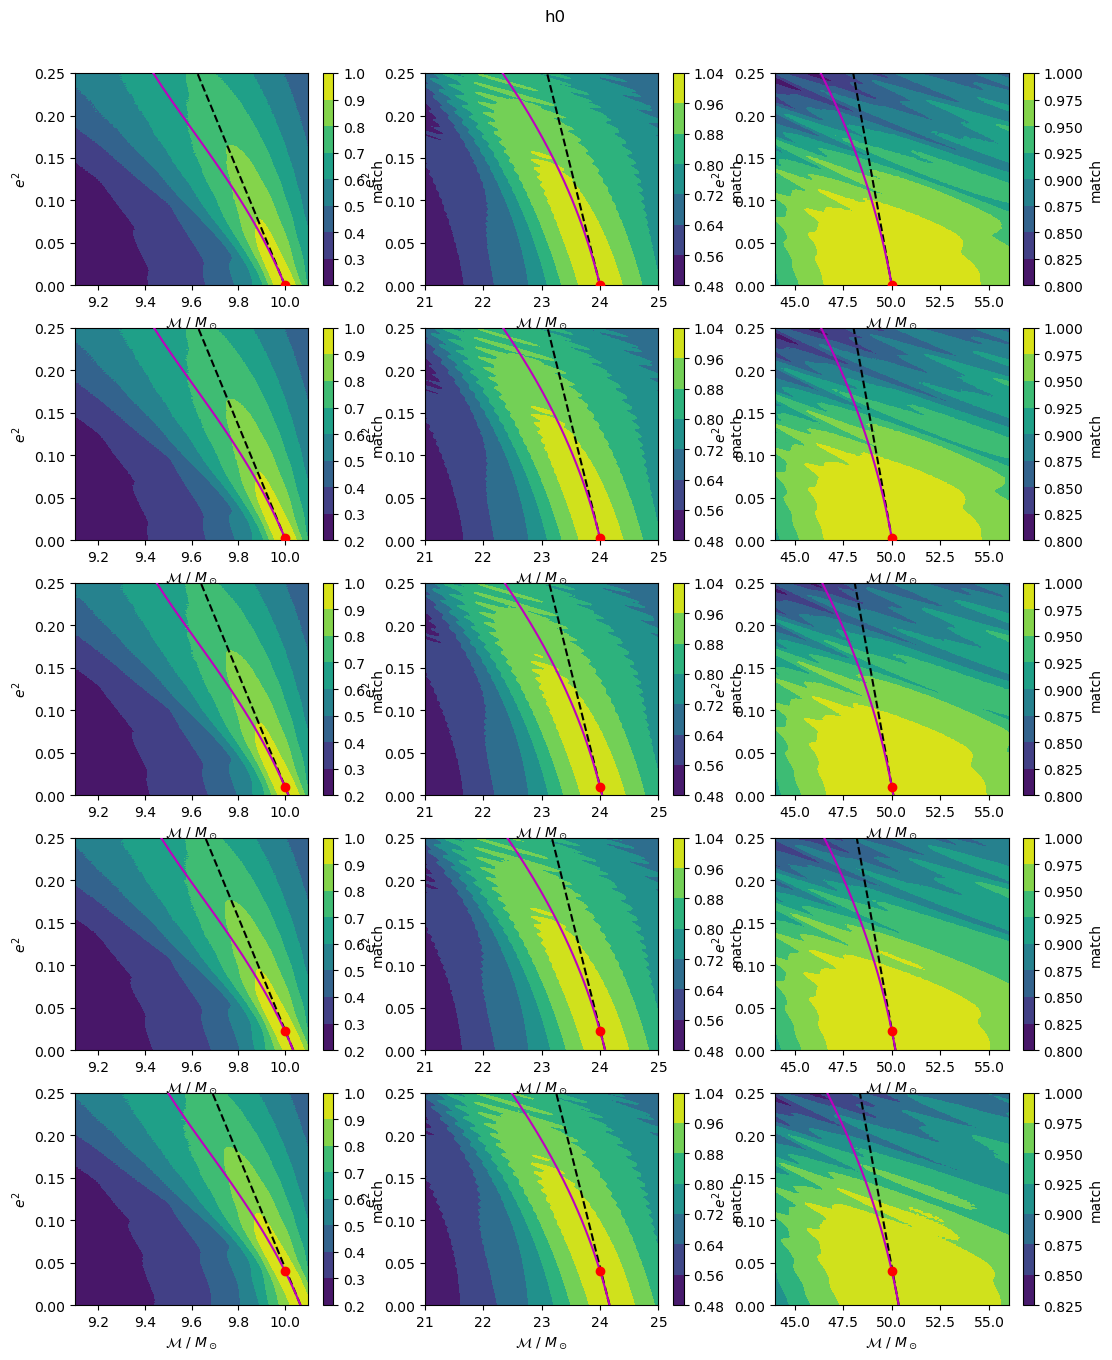

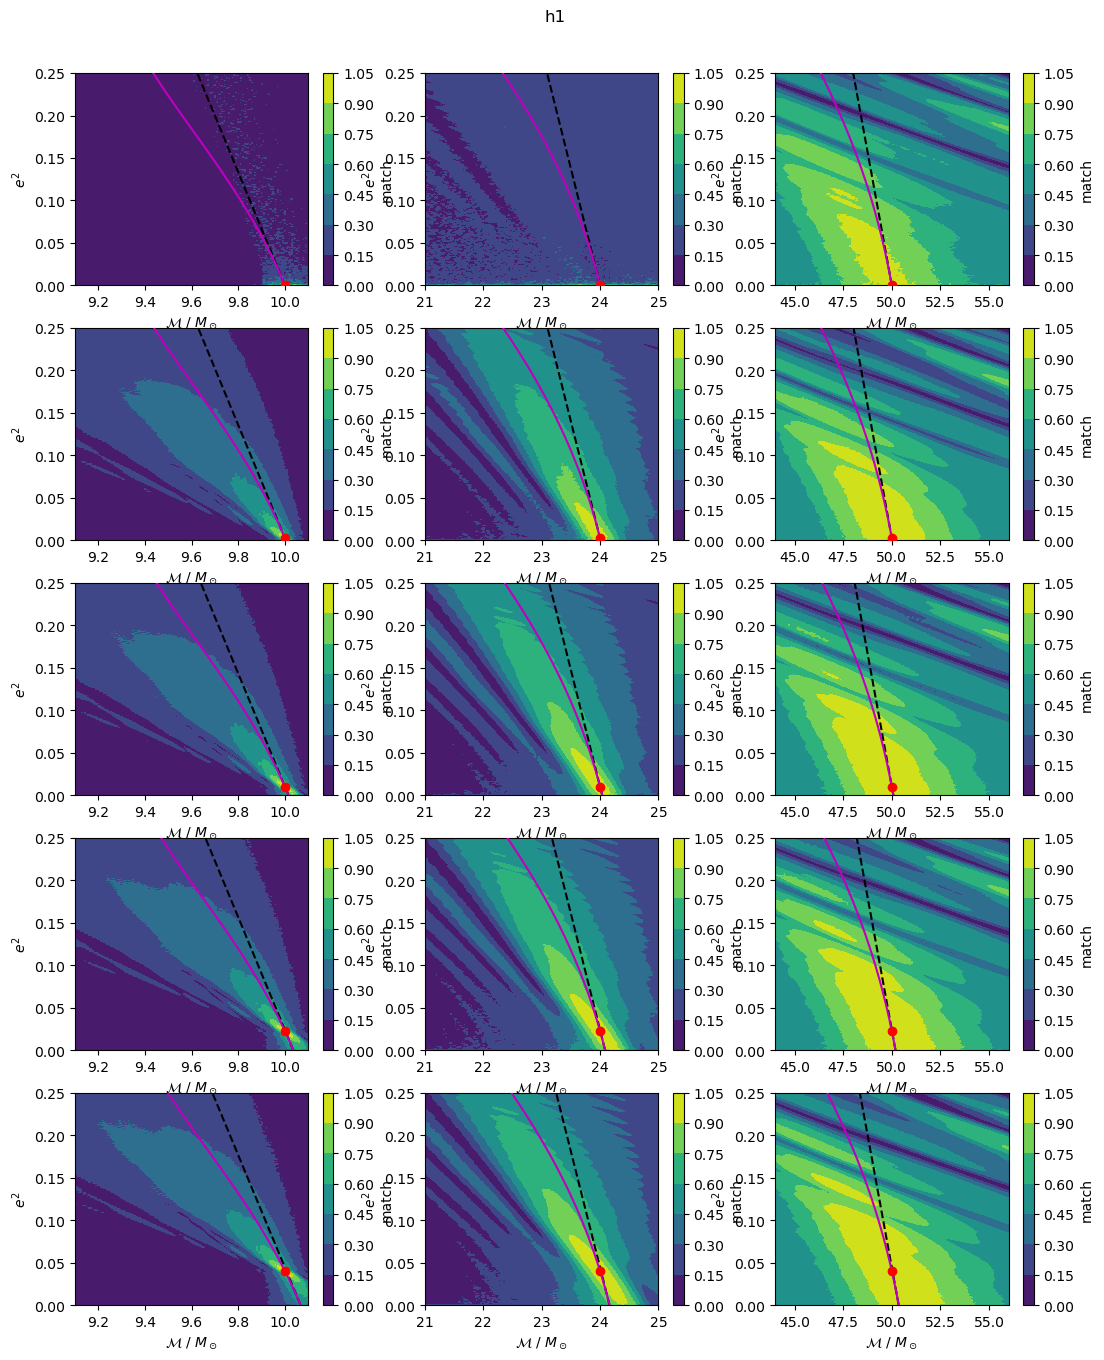

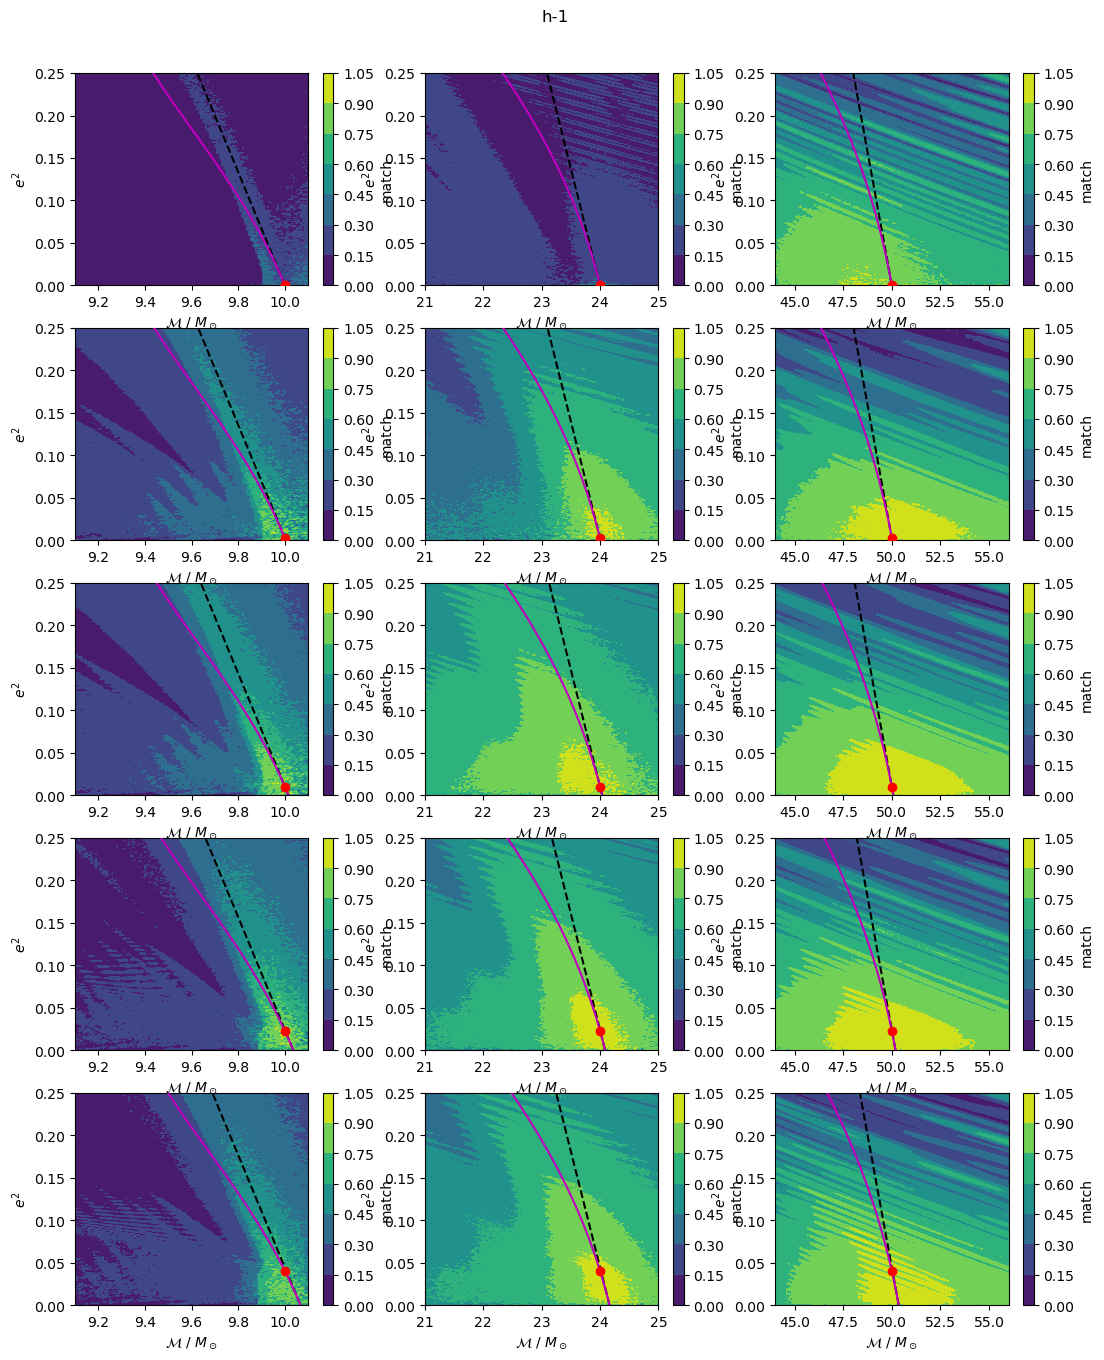

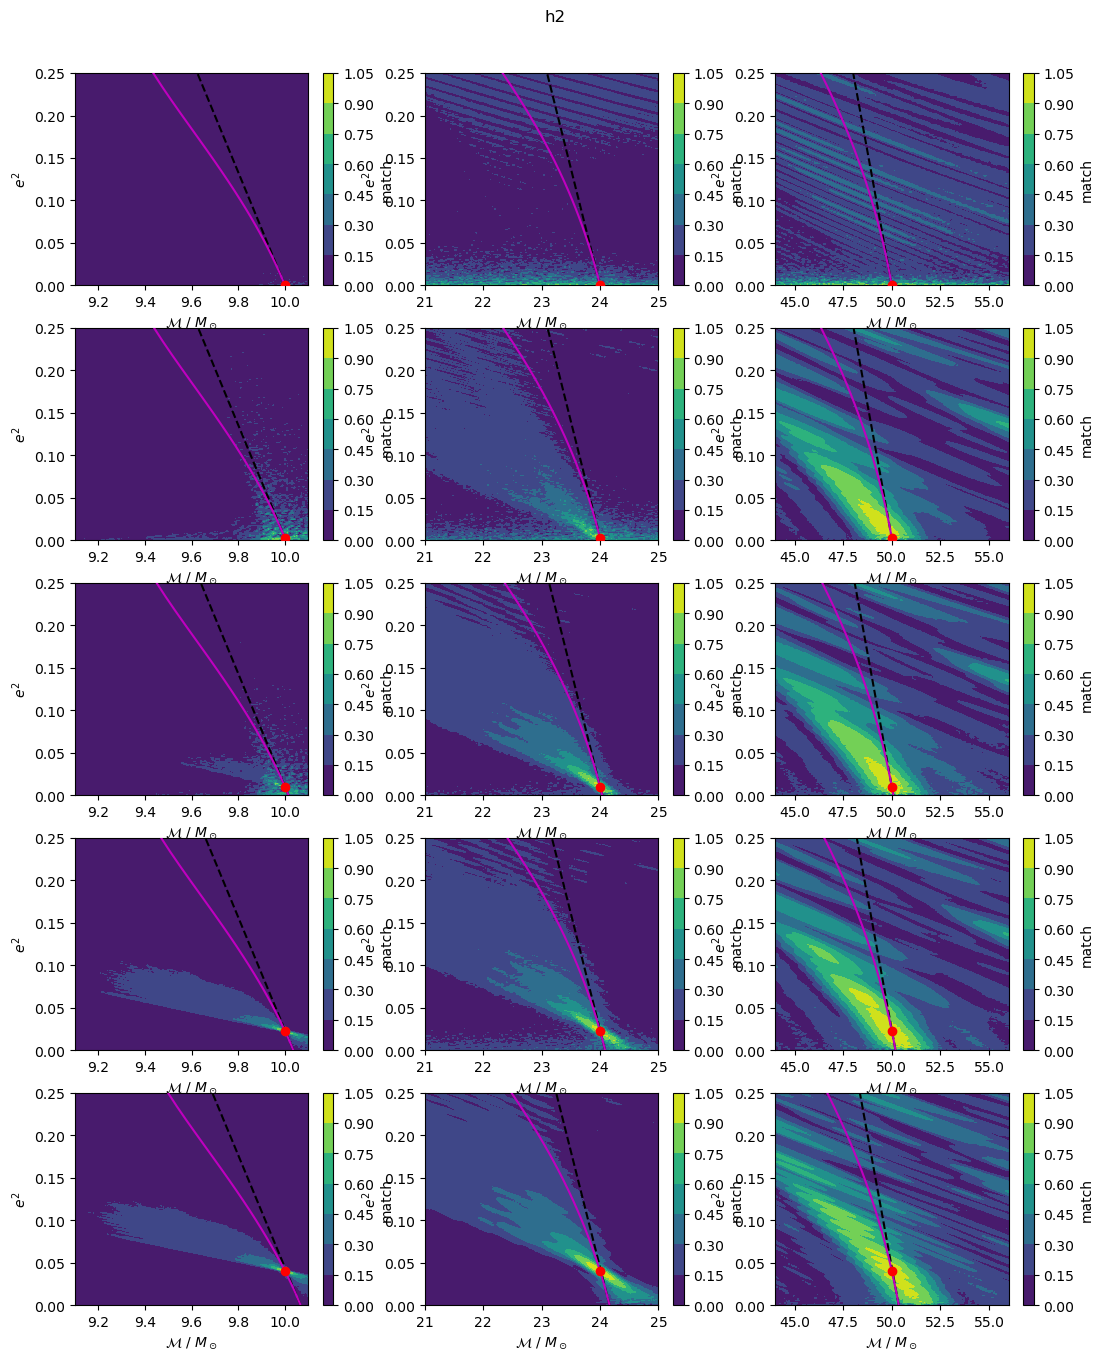

In [6]:
for key in ['h0', 'h1', 'h-1', 'h2']:
    
    # Plot each grid
    plt.figure(figsize=(6.4*2,4.8*10/3))
    for i, fid_chirp in enumerate(data.keys()):
        for j, fid_e in enumerate(data[fid_chirp].keys()):
    
            # Plot grid
            plt.subplot(len(data[fid_chirp].keys()), len(data.keys()), j*len(data.keys())+i+1)
            plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals']**2, data[fid_chirp][fid_e][key])
            plt.colorbar(label='match')
            plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
            xlims = plt.gca().get_xlim()
            ylims = plt.gca().get_ylim()
    
            # Plot degeneracy lines
            plt.plot(sparse_chirp_vals[fid_chirp][fid_e], sparse_e_vals**2, c='m', label='full', zorder=3)
            plt.plot(approx_chirp_vals[fid_chirp][fid_e], sparse_e_vals**2, c='k', ls='dashed', label='linear')
    
            # Plot formatting
            plt.ylim(ylims)
            plt.xlim(xlims)
            plt.xlabel('$\mathcal{M}~/~M_\odot$')
            plt.ylabel('$e^2$')
    plt.suptitle(key, x=0.5, y=0.92)
    plt.show()

# Standalone plot

In [5]:
# Load data
with open(os.path.join('harmonic_overlaps_data', 'dataslot_1', 'all_matches'), 'rb') as fp:
    data = pickle.load(fp)

fid_chirp = 24
fid_e = 0.1

# Calculate degeneracy lines
sparse_e_vals = np.linspace(data[fid_chirp][fid_e]['e_vals'][0], data[fid_chirp][fid_e]['e_vals'][-1], 31)
init_guess = fid_chirp
sample_rate = data[fid_chirp][fid_e]['fid_params']['sample_rate']
f_low = data[fid_chirp][fid_e]['fid_params']['f_low']
q = data[fid_chirp][fid_e]['fid_params']['q']
min_func = lambda x: abs(chirp_degeneracy_line(x, fid_e, sample_rate=sample_rate, f_low=f_low, q=q) - fid_chirp)
zero_ecc_chirp_mass = minimize(min_func, init_guess, bounds=[(0.75*init_guess, 1.25*init_guess)], method='Nelder-Mead')['x']
sparse_chirp_vals = chirp_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)
approx_chirp_vals = linear_degeneracy_line(zero_ecc_chirp_mass, sparse_e_vals, sample_rate=sample_rate, f_low=f_low, q=q)

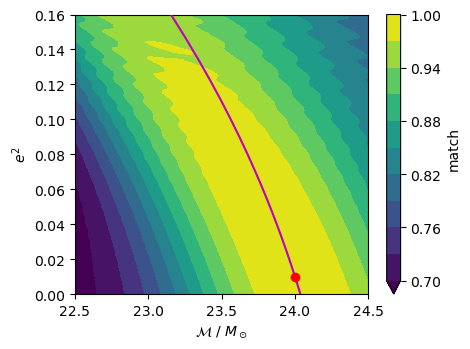

In [21]:
key = 'h0'

# Plot grid
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(data[fid_chirp][fid_e]['chirp_vals'], data[fid_chirp][fid_e]['e_vals']**2, data[fid_chirp][fid_e][key], np.linspace(0.7, 1, 11), vmax=1, vmin=0.7, extend='min')
plt.colorbar(label='match')
plt.scatter(fid_chirp, fid_e**2, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plot degeneracy lines
plt.plot(sparse_chirp_vals, sparse_e_vals**2, c='m', label='full', zorder=3)
#plt.plot(approx_chirp_vals, sparse_e_vals**2, c='k', ls='dashed', label='linear')

# Plot formatting
plt.ylim(0,0.16)
plt.xlim(22.5,24.5)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')
plt.tight_layout()
plt.savefig('Figures/e_sqrd_chirp.png', dpi=450)